In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import nibabel as nib
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import time
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import json
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import psutil

def print_memory_info():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()

    print(f"Python process RAM usage: {mem_info.rss / 1e9:.2f} GB")

print_memory_info()

Python process RAM usage: 0.51 GB


## Data

The following code creates a temporary in-memory file system and loads the training data into there. This is a workaround for the fact that there isn't enough space on the UGent HPC.

In [3]:
import sys
sys.path.append("../../")
import utils.hpc

DATA_DIR = utils.hpc.load_dataset_into_ram() if utils.hpc.running_on_hpc() else "/home/a3j/school/dl/project/3d/data/partial/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

print(f'Running on {"hpc" if utils.hpc.running_on_hpc() else "personal computer"}')
print(f'Using {"full dataset" if utils.hpc.running_on_hpc() else "partial dataset (10 patients)"}')
print(f'path: {DATA_DIR}')

Running on hpc
Using full dataset
path: /dev/shm/brats_data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData


In [4]:
def get_all_patient_folders(data_dir=DATA_DIR, broken_patients=["BraTS20_Training_355"]):
    all_patients = sorted([
        f for f in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, f)) and not f in broken_patients
    ])

    return all_patients

MODALITIES = ["flair", "t1", "t1ce", "t2"]
CLASSES = [ "Background", "NCR/NET (Necrotic)", "Edema", "Enhancing tumor"]

patient_folders = get_all_patient_folders()

print(f'Found {len(patient_folders)} patient folders')

Found 368 patient folders


In [5]:
def visualize_patient(slice_idx, imgs, seg, pred=None, show=True):
    fig, axes = plt.subplots(1, 5 if pred is None else 6, figsize=(20, 4))

    # Plot all 4 modalities
    ims = []
    for i, (img, mod) in enumerate(zip(imgs, MODALITIES)):
        im = axes[i].imshow(img[:, :, slice_idx], cmap='gray')
        axes[i].set_title(mod, fontsize=12, fontweight='bold')
        axes[i].axis('off')
        ims.append(im)

    # Plot segmentation with color-coded tumor regions
    im_seg = axes[4].imshow(seg[:, :, slice_idx], cmap='jet', vmin=0, vmax=4)
    axes[4].set_title('Segmentation', fontsize=12, fontweight='bold')
    axes[4].axis('off')
    ims.append(im_seg)

    if not pred is None:
        im_pred = axes[5].imshow(pred[:, :, slice_idx], cmap='jet', vmin=0, vmax=4)
        axes[5].set_title('Prediction', fontsize=12, fontweight='bold')
        axes[5].axis('off')
        ims.append(im_pred)


    plt.suptitle(f'Slice {slice_idx}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if show: plt.show()

    return fig, ims

In [6]:
from matplotlib.animation import FuncAnimation

def animate_patient(imgs, seg, pred=None, interval=100, save_path=None):
    fig, ims = visualize_patient(0, imgs, seg, pred, show=False)

    def update(slice_idx):
        for i, img in enumerate(imgs):
            ims[i].set_array(img[:, :, slice_idx])
        ims[4].set_array(seg[:, :, slice_idx])
        if pred is not None:
            ims[5].set_array(pred[:, :, slice_idx])
        fig.suptitle(f'Slice {slice_idx}', fontsize=14, fontweight='bold')
        return ims

    anim = FuncAnimation(fig, update, frames=imgs[0].shape[2], interval=interval, blit=False)

    if save_path:
        ext = save_path.split('.')[-1]
        if ext.lower() == 'gif':
            anim.save(save_path, writer='pillow')
        else:
            anim.save(save_path, writer='ffmpeg')
    else:
        plt.show()

(240, 240, 155)
0 (240, 240, 155) flair
1 (240, 240, 155) t1
2 (240, 240, 155) t1ce
3 (240, 240, 155) t2


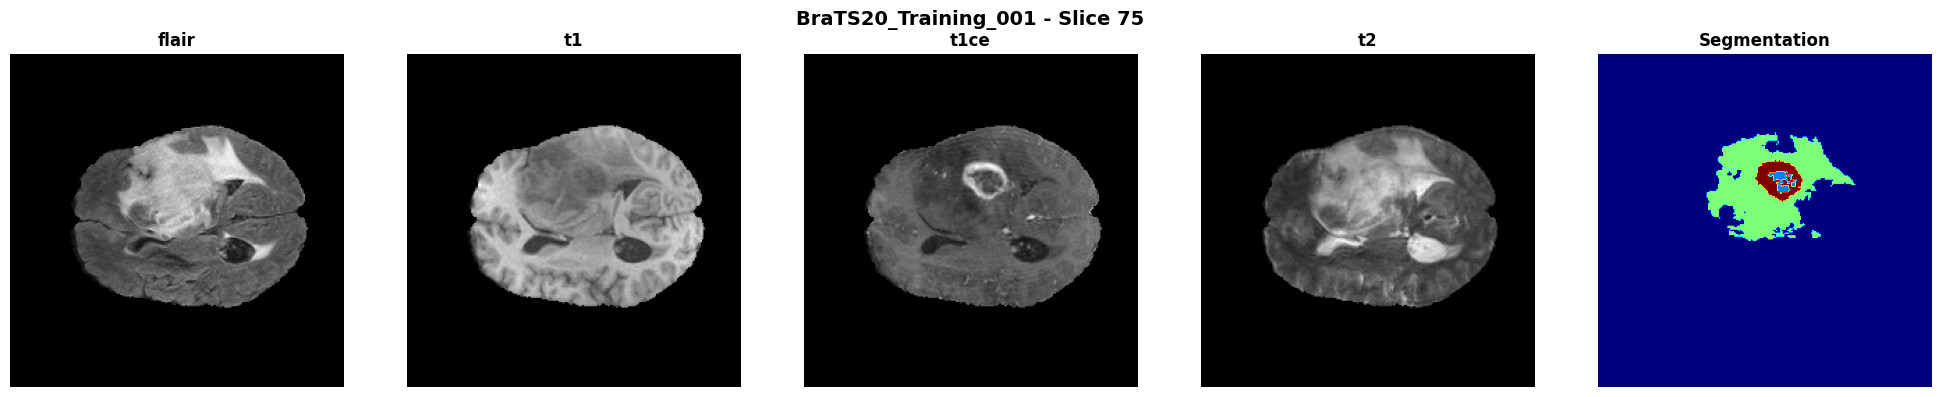

In [7]:
def display_patient(pid, slice_idx, model=None, device=None):
    path = f'{DATA_DIR}/{pid}'

    imgs = []
    for mod in MODALITIES:
        file_path = os.path.join(path, f"{pid}_{mod}.nii")
        img = nib.load(file_path).get_fdata(dtype=np.float32)
        imgs.append(img)

    seg_path = os.path.join(path, f"{pid}_seg.nii")
    seg = nib.load(seg_path).get_fdata(dtype=np.float32)

    print(imgs[0].shape)

    fig, axes = plt.subplots(1, 5 if model == None else 6, figsize=(20, 4))

    # Plot all 4 modalities
    for i, (img, mod) in enumerate(zip(imgs, MODALITIES)):
        print(i, img.shape, mod)
        axes[i].imshow(img[:, :, slice_idx], cmap='gray')
        axes[i].set_title(mod, fontsize=12, fontweight='bold')
        axes[i].axis('off')

    # Plot segmentation with color-coded tumor regions
    axes[4].imshow(seg[:, :, slice_idx], cmap='jet', vmin=0, vmax=4)
    axes[4].set_title('Segmentation', fontsize=12, fontweight='bold')
    axes[4].axis('off')

    if model != None:
        imgs_stacked = np.stack(imgs, axis=0).transpose((0, 3, 1, 2))
        imgs_tensor = torch.from_numpy(imgs_stacked).unsqueeze(0).to(device)

        model.eval()
        with torch.no_grad():
            logits = model(imgs_tensor)
            pred = torch.argmax(logits, dim=1)[0]

        pred = pred.cpu().numpy()

        axes[5].imshow(pred[:, :, slice_idx], cmap='jet', vmin=0, vmax=4)
        axes[4].set_title('Prediction', fontsize=12, fontweight='bold')
        axes[4].axis('off')

    plt.suptitle(f'{pid} - Slice {slice_idx}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

display_patient(patient_folders[0], 75)

## Creating access to the dataset

In [8]:
def pad_to_multiple(tensor, multiple=16):
    if tensor.dim() == 3:
        d, h, w = tensor.shape
    elif tensor.dim() == 4:
        c, d, h, w = tensor.shape
    else:
        raise ValueError(f"Unsupported tensor shape: {tensor.shape}")

    pad_d = (multiple - d % multiple) % multiple
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    # F.pad pads in order: (W_left, W_right, H_top, H_bottom, D_front, D_back)
    return F.pad(tensor, (0, pad_w, 0, pad_h, 0, pad_d))

In [9]:
def load_patient(patient_id):
    """Load all modalities and segmentation for one patient"""
    patient_path = os.path.join(DATA_DIR, patient_id)
    modalities = MODALITIES

    image_arrays = []
    for mod in modalities:
        file_path = os.path.join(patient_path, f"{patient_id}_{mod}.nii")
        img = nib.load(file_path).get_fdata(dtype=np.float32)
        image_arrays.append(img)

    seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii")
    seg = nib.load(seg_path).get_fdata(dtype=np.float32)

    # Stack modalities -> shape (4, D, H, W)
    image = np.stack(image_arrays, axis=0)
    #seg = np.expand_dims(seg, axis=0)  # shape (1, D, H, W)

    print(image.shape)
    print(seg.shape)

    seg[seg==4] = 3 # remap label 4 to 3 to preserve continuity (there is no label 3 in the data)

    # Normalize each modality to [0, 1]
    image = (image - image.min(axis=(1,2,3), keepdims=True)) / (
        image.max(axis=(1,2,3), keepdims=True) - image.min(axis=(1,2,3), keepdims=True) + 1e-8
    )

    # Convert to torch tensors
    image = torch.from_numpy(image).float()
    seg = torch.from_numpy(seg).long()

    # fix issues with height not being properly divisible
    image = pad_to_multiple(image)
    seg = pad_to_multiple(seg)

    print(image.shape)
    print(seg.shape)

    return image, seg

load_patient(patient_folders[0])

(4, 240, 240, 155)
(240, 240, 155)
torch.Size([4, 240, 240, 160])
torch.Size([240, 240, 160])


(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
       

In [10]:
def load_patient(patient_id, data_dir):
    """Load all modalities and segmentation for one patient"""
    patient_path = os.path.join(data_dir, patient_id)
    modalities = MODALITIES

    image_arrays = []
    for mod in modalities:
        file_path = os.path.join(patient_path, f"{patient_id}_{mod}.nii")
        img = nib.load(file_path).get_fdata(dtype=np.float32)
        image_arrays.append(img)

    seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii")
    seg = nib.load(seg_path).get_fdata(dtype=np.float32)

    # Stack modalities -> shape (4, D, H, W)
    image = np.stack(image_arrays, axis=0)
    # removed line to get shape (D, H, W)
    # seg = np.expand_dims(seg, axis=0)  # shape (1, D, H, W)

    seg[seg==4] = 3 # remap label 4 to 3 to preserve continuity (there is no label 3 in the data)

    return image, seg

def cleanup_item(image, seg, transform=None):
    # Normalize each modality to [0, 1]
    image = (image - image.min(axis=(1,2,3), keepdims=True)) / (
        image.max(axis=(1,2,3), keepdims=True) - image.min(axis=(1,2,3), keepdims=True) + 1e-8
    )

    # Apply transform if any
    if transform:
        image, seg = transform(image, seg)

    # Convert to torch tensors
    image = torch.from_numpy(image).float()
    seg = torch.from_numpy(seg).long()

    # fix issues with height not being properly divisible
    image = pad_to_multiple(image)
    seg = pad_to_multiple(seg)

    return image, seg

class BraTSDataset3D(Dataset):
    """
    PyTorch Dataset for BraTS 2020 Brain Tumor Segmentation (2D U-Net)
    
    Design Decisions:
    1. Filter empty slices: Only keep slices with tumor pixels (labels 1,2,4)
    2. Label remapping: {0,1,2,4} → {0,1,2,3} for PyTorch compatibility
    3. Normalization: Percentile clipping + Z-score on BRAIN REGION ONLY
    4. Input: 4-channel (T1, T1ce, T2, FLAIR) x 240x240 full slices
    5. Patient-level split: Prevent data leakage
    """
        
    def __init__(self, data_dir, patient_ids=None, transform=None, in_memory=False):
        """
        Args:
            data_dir (str): Path or filesystem handle to training data (with patient folders)
            patient_ids (list[str], optional): Subset of patient folder names
            transform (callable, optional): Transform applied to each sample
            in_memory (bool): If True, preloads all patients into RAM
        """
        self.data_dir = data_dir
        self.transform = transform

        # Gather all patient folders
        self.patient_ids = patient_ids or get_all_patient_folders(data_dir)

        self.in_memory = in_memory
        if in_memory:
            print("Preloading all patient data into memory...")
            self.cache = {pid: self._load_patient(pid) for pid in self.patient_ids}
        else:
            self.cache = {}        

    def _load_patient(self, patient_id):
        return load_patient(patient_id, self.data_dir)
    
    def __len__(self):
        return len(self.patient_ids)
    
    def __getitem__(self, idx):
        pid = self.patient_ids[idx]
        if pid in self.cache:
            image, seg = self.cache[pid]
        else:
            image, seg = self._load_patient(pid)

        return cleanup_item(image, seg, self.transform)
    
    def _convert_labels(self, mask):
        """
        Remap labels from {0,1,2,4} to {0,1,2,3}
        
        Original BraTS labels:
            0 = Background
            1 = Necrotic/Non-enhancing tumor
            2 = Edema
            4 = Enhancing tumor
        
        Remapped labels (for PyTorch):
            0 = Background
            1 = Necrotic/Non-enhancing tumor
            2 = Edema
            3 = Enhancing tumor
        
        Args:
            mask (np.ndarray): Segmentation mask with original labels
        
        Returns:
            np.ndarray: Mask with remapped labels
        """
        mask = mask.copy()
        mask[mask == 4] = 3  # Remap enhancing tumor
        return mask


In [11]:
from sklearn.model_selection import train_test_split

def create_split(pids=None, train=0.7, val=0.15, test=0.15):
    if not pids:
        pids = sorted(get_all_patient_folders())

    train_ids, temp_ids = train_test_split(pids, test_size=val+test, random_state=42)
    val_ids, test_ids = train_test_split(temp_ids, test_size=test/(val+test), random_state=42)

    return train_ids, val_ids, test_ids

## The model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.enc4 = DoubleConv(128, 256)

        self.pool = nn.MaxPool3d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.up4 = nn.ConvTranspose3d(512, 256, 2, stride=2)
        self.dec4 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose3d(256, 128, 2, stride=2)
        self.dec3 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b) 
        d4 = self.dec4(torch.cat([d4, e4], dim=1)) 
        d3 = self.up3(d4) 
        d3 = self.dec3(torch.cat([d3, e3], dim=1)) 
        d2 = self.up2(d3) 
        d2 = self.dec2(torch.cat([d2, e2], dim=1)) 
        d1 = self.up1(d2) 
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.out_conv(d1)
    
def create_model(in_channels=4, out_channels=4, device=None):
    """
    Create U-Net model and move to appropriate device
    
    Args:
        n_channels (int): Number of input channels
        n_classes (int): Number of output classes
        bilinear (bool): Use bilinear upsampling
        dropout_p (float): Dropout probability
        device (str or torch.device): Device to use (None = auto-detect)
    
    Returns:
        model: U-Net model on specified device
        device: The device being used
    """
    # Create model
    model = UNet3D(
        in_channels=in_channels,
        out_channels=out_channels,
    )

    model = model.to(device)
    
    return model

In [13]:
def load_and_predict_patient(pid, model, device):
    image, seg = load_patient(pid, DATA_DIR)

    model.eval()
    with torch.no_grad():
        imgs_tensor, _ = cleanup_item(image, seg)

        imgs_tensor = imgs_tensor.unsqueeze(0).to(device)

        logits = model(imgs_tensor)                   # (1, num_classes, D, H, W)
        pred_mask = torch.argmax(logits, dim=1)[0]    # remove batch dim -> (D, H, W)

    return image, seg, pred_mask.cpu().numpy()

In [14]:
def predict_patient(pid, model, device):
    _, _, pred = load_and_predict_patient(pid, model, device)
    return pred

## Loss functions

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        """
        logits: (N, C, D, H, W) raw output from model (not softmaxed)
        targets: (N, D, H, W) ground truth with class indices 0..C-1
        """
        num_classes = logits.shape[1]

        # Apply softmax over the class dimension
        probs = F.softmax(logits, dim=1)

        # One-hot encode the targets
        targets_onehot = F.one_hot(targets, num_classes).permute(0, 4, 1, 2, 3).float()

        # Compute Dice per class
        dims = (0, 2, 3, 4)
        intersection = torch.sum(probs * targets_onehot, dims)
        cardinality = torch.sum(probs + targets_onehot, dims)

        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        dice_loss = 1. - dice_score

        # Average over classes
        return dice_loss.mean()
        

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_ce=1.0):
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.dice = DiceLoss()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        dice_loss = self.dice(logits, targets)
        return self.weight_ce * ce_loss + self.weight_dice * dice_loss

## Metrics

In [16]:
class SegmentationMetrics:
    """
    Compute segmentation metrics for multi-class 3D images.
    
    Usage:
        metrics = SegmentationMetrics(num_classes=4, ignore_background=True, device='cuda')
        metrics.update(preds, targets)
        summary = metrics.get_metrics()
        metrics.reset()
    """
    
    def __init__(self, num_classes=4, ignore_background=True, device='cuda'):
        self.num_classes = num_classes
        self.ignore_background = ignore_background
        self.device = device
        self.reset()
    
    def reset(self):
        self.intersections = torch.zeros(self.num_classes, device=self.device)
        self.unions = torch.zeros(self.num_classes, device=self.device)
        self.correct_pixels = 0
        self.total_pixels = 0
        self.total_batches = 0
    
    def update(self, preds, targets):
        """
        preds: torch.Tensor of shape [B, C, H, W, D] (logits)
        targets: torch.Tensor of shape [B, H, W, D] (integer labels)
        """
        # Convert logits to predicted class labels
        if preds.dim() == targets.dim() + 1:
            preds = torch.argmax(preds, dim=1)
        
        preds = preds.to(self.device)
        targets = targets.to(self.device)
        
        # Pixel accuracy
        self.correct_pixels += (preds == targets).sum()
        self.total_pixels += torch.numel(targets)
        
        # Compute intersection & union per class
        for cls in range(self.num_classes):
            if self.ignore_background and cls == 0:
                continue
            pred_mask = (preds == cls)
            target_mask = (targets == cls)
            intersection = (pred_mask & target_mask).sum()
            union = (pred_mask | target_mask).sum()
            
            self.intersections[cls] += intersection
            self.unions[cls] += union
        
        self.total_batches += 1
    
    def get_metrics(self):
        """
        Returns a dictionary with mean dice, mean IoU, pixel accuracy,
        and per-class dice/IoU
        """
        # Dice: 2 * intersection / (pred + target)
        dice_per_class = torch.zeros(self.num_classes, device=self.device)
        iou_per_class = torch.zeros(self.num_classes, device=self.device)
        
        for cls in range(self.num_classes):
            if self.ignore_background and cls == 0:
                dice_per_class[cls] = float('nan')
                iou_per_class[cls] = float('nan')
                continue
            inter = self.intersections[cls].float()
            union = self.unions[cls].float()
            dice_per_class[cls] = 2 * inter / (union + inter + 1e-8)
            iou_per_class[cls] = inter / (union + 1e-8)
        
        # Mean dice & IoU (excluding background if desired)
        valid_dice = dice_per_class[1:] if self.ignore_background else dice_per_class
        valid_iou = iou_per_class[1:] if self.ignore_background else iou_per_class
        
        mean_dice = valid_dice[~torch.isnan(valid_dice)].mean().item()
        mean_iou = valid_iou[~torch.isnan(valid_iou)].mean().item()
        pixel_acc = (self.correct_pixels.float() / self.total_pixels).item()
        
        return {
            'mean_dice': mean_dice,
            'mean_iou': mean_iou,
            'mean_pixel_acc': pixel_acc,
            'dice_per_class': dice_per_class.cpu().tolist(),
            'iou_per_class': iou_per_class.cpu().tolist()
        }


## Helper functions

In [17]:
def save_model(model, epoch, optimizer, val_dice, val_loss, train_metrics_dict, val_metrics_dict, save_dir, today=None, final=False):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_dice': val_dice,
        'val_loss': val_loss,
        'train_metrics': train_metrics_dict, 
        'val_metrics': val_metrics_dict,
    }
    
    if today is None:
        today = datetime.now().strftime("%Y%m%d_%H%M%S")
    torch.save(checkpoint, save_dir / f'{today}_{"final" if final else "best"}_model.pth')

def save_history(history, save_dir, today=None):
    if today is None:
        today = datetime.now().strftime("%Y%m%d_%H%M%S")
    history_file = save_dir / f'{today}_training_history.json'
    with open(history_file, 'w') as f:
        json.dump(history, f, indent=4)


In [18]:
def update_history(history, train_loss, val_loss, train_metrics_dict, val_metrics_dict, epoch_time):
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_metrics_dict['mean_dice'])
    history['val_dice'].append(val_metrics_dict['mean_dice'])
    history['train_iou'].append(train_metrics_dict['mean_iou'])
    history['val_iou'].append(val_metrics_dict['mean_iou'])
    history['train_pixel_acc'].append(train_metrics_dict['mean_pixel_acc'])
    history['val_pixel_acc'].append(val_metrics_dict['mean_pixel_acc'])
    history['epoch_times'].append(epoch_time)

## Training loop

In [19]:
def train_epoch(model, loader, loss_fn, optimizer, device, metrics, verbose=True):
    model.train()
    
    running_loss = 0.0
    num_batches = 0
    
    if verbose:
        loader = tqdm(loader, desc='Training', ncols=100)
    
    for batch_idx, (inputs, targets) in enumerate(loader):
        # Move to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = loss_fn(outputs, targets.squeeze(1))
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Track running loss
        running_loss += loss.item()
        num_batches += 1
        
        # Optionally compute batch metrics
        metrics.update(outputs.detach(), targets.detach())
        
        if verbose:
            avg_loss = running_loss / num_batches
            loader.set_postfix({'loss': f'{avg_loss:.4f}'})
    
    # Average epoch loss
    epoch_loss = running_loss / num_batches
    
    # Get metrics summary (if any)
    metrics_summary = metrics.get_metrics()
    
    return epoch_loss, metrics_summary

def validate_epoch(model, loader, loss_fn, device, metrics):
    model.eval()
    metrics.reset()
    running_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(loader):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = loss_fn(outputs, masks.squeeze(1))
            running_loss += loss.item()
            num_batches += 1

            # Update metrics
            metrics.update(outputs, masks)

    avg_loss = running_loss / max(num_batches, 1)
    metrics_dict = metrics.get_metrics()

    return avg_loss, metrics_dict

In [24]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, device, save_dir="checkpoints", epochs=20, scheduler=None, early_stopping_patience=None):
    try:
        today = datetime.now().strftime("%Y%m%d_%H%M%S")
        save_dir = Path(save_dir)
        save_dir.mkdir(exist_ok=True, parents=True)

        train_metrics = SegmentationMetrics(num_classes=4, ignore_background=True, device=device)
        val_metrics = SegmentationMetrics(num_classes=4, ignore_background=True, device=device)

        history = {
            'train_loss': [],
            'val_loss': [],
            'train_dice': [],
            'val_dice': [],
            'train_iou': [],
            'val_iou': [],
            'train_pixel_acc': [],
            'val_pixel_acc': [],
            'epoch_times': []
        }

        best_val_dice = 0.0
        best_epoch = 0
        epochs_without_improvement = 0

        for epoch in range(epochs):
            epoch_start_time = time.time()

            # training phase
            train_loss, train_metrics_dict = train_epoch(model, train_loader, loss_fn, optimizer, device, train_metrics)

            # validation phase
            val_loss, val_metrics_dict = validate_epoch(model, val_loader, loss_fn, device, val_metrics)

            # step scheduler
            if scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(val_loss)
                else:
                    scheduler.step()


            epoch_time = time.time() - epoch_start_time

            # update history
            update_history(history, train_loss, val_loss, train_metrics_dict, val_metrics_dict, epoch_time)

            # show metrics
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Epoch time: {epoch_time:.2f}s")
            print(f"Train Dice: {train_metrics_dict['mean_dice']:.4f} | Val Dice: {val_metrics_dict['mean_dice']:.4f}")
            print(f"Train IoU: {train_metrics_dict['mean_iou']:.4f} | Val IoU: {val_metrics_dict['mean_iou']:.4f}")
            print(f"Train Pixel Acc: {train_metrics_dict['mean_pixel_acc']:.4f} | Val Pixel Acc: {val_metrics_dict['mean_pixel_acc']:.4f}")

            # save model if best
            val_dice = val_metrics_dict['mean_dice']

            if val_dice > best_val_dice:
                print(f'Saving new best model: {val_dice:.4f} > {best_val_dice:.4f}')

                best_val_dice = val_dice
                best_epoch = epoch + 1
                epochs_without_improvement = 0

                save_model(model, best_epoch, optimizer, val_dice, val_loss, train_metrics_dict, val_metrics_dict, save_dir, today=today, final=False)
            else:
                epochs_without_improvement += 1

            if early_stopping_patience and epochs_without_improvement >= early_stopping_patience:
                print(f"Warning: Early stopping triggered")
                break
    except KeyboardInterrupt:
        print("Interrupted manually. Saving history...")
    finally:
        # save final model
        save_history(history, save_dir, today=today)

    return history

## Execution

In [21]:
device = torch.device("cuda:0")
#device = torch.device("cpu")

print(f'Using device: {device}')

Using device: cuda:0


In [22]:
# create datasets
train_ids, val_ids, test_ids = create_split()

print(f'Split: {len(train_ids)} training, {len(val_ids)} validation, {len(test_ids)} test')

train_dataset = BraTSDataset3D(
    data_dir=DATA_DIR,
    patient_ids=train_ids,
    transform=None,
    in_memory=False,
)

val_dataset = BraTSDataset3D(
    data_dir=DATA_DIR,
    patient_ids=val_ids,
    transform=None,
    in_memory=False,
)

test_dataset = BraTSDataset3D(
    data_dir=DATA_DIR,
    patient_ids=test_ids,
    transform=None,
    in_memory=False,
)

# create dataloaders
BATCH_SIZE = 2
NUM_WORKERS = 1

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# create model
model = create_model(device=device)
model = model.to(device)

# create loss function
loss_fn = CombinedLoss()

# create optimizer
learning_rate = 1e-4
weight_decay = 1e-5

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Split: 257 training, 55 validation, 56 test


In [25]:
history = train_model(model, train_loader, val_loader, loss_fn, optimizer, device, epochs=60)

Training: 100%|██████████████████████████████████████| 129/129 [03:04<00:00,  1.43s/it, loss=1.9066]


Train Loss: 1.9066 | Val Loss: 1.7558 | Epoch time: 215.05s
Train Dice: 0.0716 | Val Dice: 0.0593
Train IoU: 0.0387 | Val IoU: 0.0325
Train Pixel Acc: 0.9232 | Val Pixel Acc: 0.9380
Saving new best model: 0.0593 > 0.0000


Training: 100%|██████████████████████████████████████| 129/129 [03:00<00:00,  1.40s/it, loss=1.5794]


Train Loss: 1.5794 | Val Loss: 1.5220 | Epoch time: 210.41s
Train Dice: 0.0976 | Val Dice: 0.1078
Train IoU: 0.0555 | Val IoU: 0.0640
Train Pixel Acc: 0.9544 | Val Pixel Acc: 0.9849
Saving new best model: 0.1078 > 0.0593


Training: 100%|██████████████████████████████████████| 129/129 [03:00<00:00,  1.40s/it, loss=1.4210]


Train Loss: 1.4210 | Val Loss: 1.3586 | Epoch time: 210.71s
Train Dice: 0.1166 | Val Dice: 0.1403
Train IoU: 0.0686 | Val IoU: 0.0843
Train Pixel Acc: 0.9668 | Val Pixel Acc: 0.9884
Saving new best model: 0.1403 > 0.1078


Training: 100%|██████████████████████████████████████| 129/129 [03:00<00:00,  1.40s/it, loss=1.2829]


Train Loss: 1.2829 | Val Loss: 1.2196 | Epoch time: 210.79s
Train Dice: 0.1410 | Val Dice: 0.2366
Train IoU: 0.0840 | Val IoU: 0.1368
Train Pixel Acc: 0.9731 | Val Pixel Acc: 0.9878
Saving new best model: 0.2366 > 0.1403


Training: 100%|██████████████████████████████████████| 129/129 [03:00<00:00,  1.40s/it, loss=1.1598]


Train Loss: 1.1598 | Val Loss: 1.1484 | Epoch time: 210.98s
Train Dice: 0.1879 | Val Dice: 0.2396
Train IoU: 0.1115 | Val IoU: 0.1422
Train Pixel Acc: 0.9770 | Val Pixel Acc: 0.9864
Saving new best model: 0.2396 > 0.2366


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.40s/it, loss=1.0603]


Train Loss: 1.0603 | Val Loss: 1.0512 | Epoch time: 211.17s
Train Dice: 0.2305 | Val Dice: 0.3320
Train IoU: 0.1381 | Val IoU: 0.2044
Train Pixel Acc: 0.9796 | Val Pixel Acc: 0.9809
Saving new best model: 0.3320 > 0.2396


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.9719]


Train Loss: 0.9719 | Val Loss: 0.9554 | Epoch time: 212.06s
Train Dice: 0.2652 | Val Dice: 0.4275
Train IoU: 0.1610 | Val IoU: 0.2753
Train Pixel Acc: 0.9816 | Val Pixel Acc: 0.9893
Saving new best model: 0.4275 > 0.3320


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.9042]


Train Loss: 0.9042 | Val Loss: 0.8985 | Epoch time: 211.42s
Train Dice: 0.2929 | Val Dice: 0.4794
Train IoU: 0.1802 | Val IoU: 0.3166
Train Pixel Acc: 0.9830 | Val Pixel Acc: 0.9930
Saving new best model: 0.4794 > 0.4275


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.8434]


Train Loss: 0.8434 | Val Loss: 0.8698 | Epoch time: 211.80s
Train Dice: 0.3192 | Val Dice: 0.3518
Train IoU: 0.1987 | Val IoU: 0.2148
Train Pixel Acc: 0.9842 | Val Pixel Acc: 0.9854


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.7913]


Train Loss: 0.7913 | Val Loss: 0.8188 | Epoch time: 211.60s
Train Dice: 0.3414 | Val Dice: 0.4292
Train IoU: 0.2149 | Val IoU: 0.2735
Train Pixel Acc: 0.9852 | Val Pixel Acc: 0.9905


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.7486]


Train Loss: 0.7486 | Val Loss: 0.7714 | Epoch time: 211.83s
Train Dice: 0.3602 | Val Dice: 0.5061
Train IoU: 0.2287 | Val IoU: 0.3397
Train Pixel Acc: 0.9859 | Val Pixel Acc: 0.9928
Saving new best model: 0.5061 > 0.4794


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.6984]


Train Loss: 0.6984 | Val Loss: 0.7268 | Epoch time: 211.75s
Train Dice: 0.3785 | Val Dice: 0.5040
Train IoU: 0.2425 | Val IoU: 0.3437
Train Pixel Acc: 0.9866 | Val Pixel Acc: 0.9935


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.6532]


Train Loss: 0.6532 | Val Loss: 0.7254 | Epoch time: 212.02s
Train Dice: 0.3946 | Val Dice: 0.3720
Train IoU: 0.2549 | Val IoU: 0.2303
Train Pixel Acc: 0.9872 | Val Pixel Acc: 0.9856


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.6065]


Train Loss: 0.6065 | Val Loss: 0.6490 | Epoch time: 211.91s
Train Dice: 0.4093 | Val Dice: 0.5105
Train IoU: 0.2663 | Val IoU: 0.3438
Train Pixel Acc: 0.9877 | Val Pixel Acc: 0.9920
Saving new best model: 0.5105 > 0.5061


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.5564]


Train Loss: 0.5564 | Val Loss: 0.5884 | Epoch time: 212.03s
Train Dice: 0.4232 | Val Dice: 0.5214
Train IoU: 0.2774 | Val IoU: 0.3588
Train Pixel Acc: 0.9881 | Val Pixel Acc: 0.9931
Saving new best model: 0.5214 > 0.5105


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.5120]


Train Loss: 0.5120 | Val Loss: 0.5893 | Epoch time: 212.00s
Train Dice: 0.4358 | Val Dice: 0.4544
Train IoU: 0.2874 | Val IoU: 0.2944
Train Pixel Acc: 0.9886 | Val Pixel Acc: 0.9889


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.4655]


Train Loss: 0.4655 | Val Loss: 0.4895 | Epoch time: 212.22s
Train Dice: 0.4479 | Val Dice: 0.5732
Train IoU: 0.2972 | Val IoU: 0.4024
Train Pixel Acc: 0.9889 | Val Pixel Acc: 0.9928
Saving new best model: 0.5732 > 0.5214


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.4143]


Train Loss: 0.4143 | Val Loss: 0.4596 | Epoch time: 211.99s
Train Dice: 0.4591 | Val Dice: 0.6054
Train IoU: 0.3066 | Val IoU: 0.4383
Train Pixel Acc: 0.9893 | Val Pixel Acc: 0.9935
Saving new best model: 0.6054 > 0.5732


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.3791]


Train Loss: 0.3791 | Val Loss: 0.4143 | Epoch time: 212.10s
Train Dice: 0.4701 | Val Dice: 0.6277
Train IoU: 0.3158 | Val IoU: 0.4693
Train Pixel Acc: 0.9896 | Val Pixel Acc: 0.9946
Saving new best model: 0.6277 > 0.6054


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.3541]


Train Loss: 0.3541 | Val Loss: 0.4077 | Epoch time: 211.98s
Train Dice: 0.4801 | Val Dice: 0.5435
Train IoU: 0.3244 | Val IoU: 0.3742
Train Pixel Acc: 0.9899 | Val Pixel Acc: 0.9908


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.3349]


Train Loss: 0.3349 | Val Loss: 0.4359 | Epoch time: 212.02s
Train Dice: 0.4895 | Val Dice: 0.5607
Train IoU: 0.3325 | Val IoU: 0.3985
Train Pixel Acc: 0.9902 | Val Pixel Acc: 0.9942


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.3150]


Train Loss: 0.3150 | Val Loss: 0.3854 | Epoch time: 211.98s
Train Dice: 0.4986 | Val Dice: 0.5431
Train IoU: 0.3403 | Val IoU: 0.3746
Train Pixel Acc: 0.9905 | Val Pixel Acc: 0.9913


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.3049]


Train Loss: 0.3049 | Val Loss: 0.3501 | Epoch time: 211.59s
Train Dice: 0.5066 | Val Dice: 0.6611
Train IoU: 0.3474 | Val IoU: 0.4982
Train Pixel Acc: 0.9907 | Val Pixel Acc: 0.9948
Saving new best model: 0.6611 > 0.6277


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2972]


Train Loss: 0.2972 | Val Loss: 0.4025 | Epoch time: 211.92s
Train Dice: 0.5139 | Val Dice: 0.5389
Train IoU: 0.3540 | Val IoU: 0.3719
Train Pixel Acc: 0.9909 | Val Pixel Acc: 0.9915


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2808]


Train Loss: 0.2808 | Val Loss: 0.4293 | Epoch time: 211.95s
Train Dice: 0.5218 | Val Dice: 0.5065
Train IoU: 0.3611 | Val IoU: 0.3400
Train Pixel Acc: 0.9911 | Val Pixel Acc: 0.9924


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2726]


Train Loss: 0.2726 | Val Loss: 0.3142 | Epoch time: 211.92s
Train Dice: 0.5290 | Val Dice: 0.6745
Train IoU: 0.3676 | Val IoU: 0.5154
Train Pixel Acc: 0.9913 | Val Pixel Acc: 0.9950
Saving new best model: 0.6745 > 0.6611


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2552]


Train Loss: 0.2552 | Val Loss: 0.3132 | Epoch time: 211.93s
Train Dice: 0.5362 | Val Dice: 0.6508
Train IoU: 0.3742 | Val IoU: 0.4909
Train Pixel Acc: 0.9915 | Val Pixel Acc: 0.9923


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2483]


Train Loss: 0.2483 | Val Loss: 0.3244 | Epoch time: 212.16s
Train Dice: 0.5430 | Val Dice: 0.6587
Train IoU: 0.3805 | Val IoU: 0.4969
Train Pixel Acc: 0.9917 | Val Pixel Acc: 0.9944


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2529]


Train Loss: 0.2529 | Val Loss: 0.3198 | Epoch time: 212.03s
Train Dice: 0.5493 | Val Dice: 0.6650
Train IoU: 0.3863 | Val IoU: 0.5050
Train Pixel Acc: 0.9918 | Val Pixel Acc: 0.9939


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2519]


Train Loss: 0.2519 | Val Loss: 0.3340 | Epoch time: 211.98s
Train Dice: 0.5552 | Val Dice: 0.6163
Train IoU: 0.3919 | Val IoU: 0.4581
Train Pixel Acc: 0.9920 | Val Pixel Acc: 0.9918


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2620]


Train Loss: 0.2620 | Val Loss: 0.3020 | Epoch time: 211.98s
Train Dice: 0.5601 | Val Dice: 0.6350
Train IoU: 0.3967 | Val IoU: 0.4695
Train Pixel Acc: 0.9921 | Val Pixel Acc: 0.9938


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2411]


Train Loss: 0.2411 | Val Loss: 0.2886 | Epoch time: 211.92s
Train Dice: 0.5655 | Val Dice: 0.6771
Train IoU: 0.4018 | Val IoU: 0.5187
Train Pixel Acc: 0.9922 | Val Pixel Acc: 0.9946
Saving new best model: 0.6771 > 0.6745


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.40s/it, loss=0.2287]


Train Loss: 0.2287 | Val Loss: 0.3300 | Epoch time: 211.38s
Train Dice: 0.5710 | Val Dice: 0.5946
Train IoU: 0.4071 | Val IoU: 0.4233
Train Pixel Acc: 0.9923 | Val Pixel Acc: 0.9925


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2348]


Train Loss: 0.2348 | Val Loss: 0.3040 | Epoch time: 211.69s
Train Dice: 0.5762 | Val Dice: 0.6535
Train IoU: 0.4121 | Val IoU: 0.4913
Train Pixel Acc: 0.9925 | Val Pixel Acc: 0.9933


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2193]


Train Loss: 0.2193 | Val Loss: 0.2819 | Epoch time: 211.72s
Train Dice: 0.5814 | Val Dice: 0.6763
Train IoU: 0.4171 | Val IoU: 0.5198
Train Pixel Acc: 0.9926 | Val Pixel Acc: 0.9944


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2154]


Train Loss: 0.2154 | Val Loss: 0.3613 | Epoch time: 211.88s
Train Dice: 0.5863 | Val Dice: 0.5392
Train IoU: 0.4220 | Val IoU: 0.3700
Train Pixel Acc: 0.9927 | Val Pixel Acc: 0.9909


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2135]


Train Loss: 0.2135 | Val Loss: 0.2980 | Epoch time: 211.75s
Train Dice: 0.5911 | Val Dice: 0.6447
Train IoU: 0.4266 | Val IoU: 0.4873
Train Pixel Acc: 0.9928 | Val Pixel Acc: 0.9938


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2157]


Train Loss: 0.2157 | Val Loss: 0.2629 | Epoch time: 211.72s
Train Dice: 0.5956 | Val Dice: 0.7008
Train IoU: 0.4311 | Val IoU: 0.5479
Train Pixel Acc: 0.9929 | Val Pixel Acc: 0.9941
Saving new best model: 0.7008 > 0.6771


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2101]


Train Loss: 0.2101 | Val Loss: 0.2773 | Epoch time: 211.72s
Train Dice: 0.6000 | Val Dice: 0.6846
Train IoU: 0.4355 | Val IoU: 0.5281
Train Pixel Acc: 0.9930 | Val Pixel Acc: 0.9934


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2104]


Train Loss: 0.2104 | Val Loss: 0.2983 | Epoch time: 211.93s
Train Dice: 0.6041 | Val Dice: 0.6445
Train IoU: 0.4396 | Val IoU: 0.4818
Train Pixel Acc: 0.9931 | Val Pixel Acc: 0.9925


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2172]


Train Loss: 0.2172 | Val Loss: 0.3115 | Epoch time: 211.94s
Train Dice: 0.6080 | Val Dice: 0.6400
Train IoU: 0.4436 | Val IoU: 0.4751
Train Pixel Acc: 0.9932 | Val Pixel Acc: 0.9941


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2133]


Train Loss: 0.2133 | Val Loss: 0.2722 | Epoch time: 211.99s
Train Dice: 0.6118 | Val Dice: 0.6813
Train IoU: 0.4474 | Val IoU: 0.5280
Train Pixel Acc: 0.9933 | Val Pixel Acc: 0.9945


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2036]


Train Loss: 0.2036 | Val Loss: 0.2800 | Epoch time: 212.08s
Train Dice: 0.6157 | Val Dice: 0.6664
Train IoU: 0.4513 | Val IoU: 0.5099
Train Pixel Acc: 0.9933 | Val Pixel Acc: 0.9930


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.1982]


Train Loss: 0.1982 | Val Loss: 0.2603 | Epoch time: 211.62s
Train Dice: 0.6195 | Val Dice: 0.6986
Train IoU: 0.4552 | Val IoU: 0.5432
Train Pixel Acc: 0.9934 | Val Pixel Acc: 0.9950


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.1997]


Train Loss: 0.1997 | Val Loss: 0.3045 | Epoch time: 211.69s
Train Dice: 0.6229 | Val Dice: 0.5946
Train IoU: 0.4588 | Val IoU: 0.4288
Train Pixel Acc: 0.9935 | Val Pixel Acc: 0.9895


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.2010]


Train Loss: 0.2010 | Val Loss: 0.2873 | Epoch time: 211.65s
Train Dice: 0.6264 | Val Dice: 0.6232
Train IoU: 0.4624 | Val IoU: 0.4587
Train Pixel Acc: 0.9936 | Val Pixel Acc: 0.9929


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.1976]


Train Loss: 0.1976 | Val Loss: 0.2860 | Epoch time: 211.66s
Train Dice: 0.6299 | Val Dice: 0.6114
Train IoU: 0.4660 | Val IoU: 0.4406
Train Pixel Acc: 0.9936 | Val Pixel Acc: 0.9925


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.1972]


Train Loss: 0.1972 | Val Loss: 0.3142 | Epoch time: 211.74s
Train Dice: 0.6331 | Val Dice: 0.5705
Train IoU: 0.4694 | Val IoU: 0.4007
Train Pixel Acc: 0.9937 | Val Pixel Acc: 0.9906


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.1955]


Train Loss: 0.1955 | Val Loss: 0.2820 | Epoch time: 212.03s
Train Dice: 0.6363 | Val Dice: 0.6632
Train IoU: 0.4727 | Val IoU: 0.5032
Train Pixel Acc: 0.9938 | Val Pixel Acc: 0.9939


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.1854]


Train Loss: 0.1854 | Val Loss: 0.2687 | Epoch time: 211.81s
Train Dice: 0.6394 | Val Dice: 0.6857
Train IoU: 0.4760 | Val IoU: 0.5298
Train Pixel Acc: 0.9938 | Val Pixel Acc: 0.9939


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.1886]


Train Loss: 0.1886 | Val Loss: 0.2686 | Epoch time: 211.90s
Train Dice: 0.6425 | Val Dice: 0.6879
Train IoU: 0.4793 | Val IoU: 0.5303
Train Pixel Acc: 0.9939 | Val Pixel Acc: 0.9937


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.1863]


Train Loss: 0.1863 | Val Loss: 0.2487 | Epoch time: 211.98s
Train Dice: 0.6455 | Val Dice: 0.7216
Train IoU: 0.4824 | Val IoU: 0.5702
Train Pixel Acc: 0.9940 | Val Pixel Acc: 0.9950
Saving new best model: 0.7216 > 0.7008


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.1871]


Train Loss: 0.1871 | Val Loss: 0.2713 | Epoch time: 211.85s
Train Dice: 0.6484 | Val Dice: 0.6692
Train IoU: 0.4855 | Val IoU: 0.5150
Train Pixel Acc: 0.9940 | Val Pixel Acc: 0.9944


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.1872]


Train Loss: 0.1872 | Val Loss: 0.2716 | Epoch time: 211.74s
Train Dice: 0.6511 | Val Dice: 0.6696
Train IoU: 0.4884 | Val IoU: 0.5115
Train Pixel Acc: 0.9941 | Val Pixel Acc: 0.9940


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.41s/it, loss=0.1885]


Train Loss: 0.1885 | Val Loss: 0.2801 | Epoch time: 211.65s
Train Dice: 0.6537 | Val Dice: 0.6246
Train IoU: 0.4911 | Val IoU: 0.4544
Train Pixel Acc: 0.9941 | Val Pixel Acc: 0.9930


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.40s/it, loss=0.1788]


Train Loss: 0.1788 | Val Loss: 0.2488 | Epoch time: 211.19s
Train Dice: 0.6564 | Val Dice: 0.7114
Train IoU: 0.4941 | Val IoU: 0.5582
Train Pixel Acc: 0.9942 | Val Pixel Acc: 0.9955


Training: 100%|██████████████████████████████████████| 129/129 [03:01<00:00,  1.40s/it, loss=0.1812]


Train Loss: 0.1812 | Val Loss: 0.2662 | Epoch time: 211.39s
Train Dice: 0.6590 | Val Dice: 0.6798
Train IoU: 0.4969 | Val IoU: 0.5237
Train Pixel Acc: 0.9942 | Val Pixel Acc: 0.9943


Training: 100%|██████████████████████████████████████| 129/129 [03:00<00:00,  1.40s/it, loss=0.1782]


Train Loss: 0.1782 | Val Loss: 0.2798 | Epoch time: 210.73s
Train Dice: 0.6616 | Val Dice: 0.6336
Train IoU: 0.4997 | Val IoU: 0.4680
Train Pixel Acc: 0.9943 | Val Pixel Acc: 0.9920


Training: 100%|██████████████████████████████████████| 129/129 [03:00<00:00,  1.40s/it, loss=0.1833]


Train Loss: 0.1833 | Val Loss: 0.2957 | Epoch time: 210.80s
Train Dice: 0.6640 | Val Dice: 0.6484
Train IoU: 0.5024 | Val IoU: 0.4887
Train Pixel Acc: 0.9943 | Val Pixel Acc: 0.9918


Training: 100%|██████████████████████████████████████| 129/129 [03:00<00:00,  1.40s/it, loss=0.1964]


Train Loss: 0.1964 | Val Loss: 0.2627 | Epoch time: 210.85s
Train Dice: 0.6662 | Val Dice: 0.6906
Train IoU: 0.5047 | Val IoU: 0.5372
Train Pixel Acc: 0.9944 | Val Pixel Acc: 0.9951


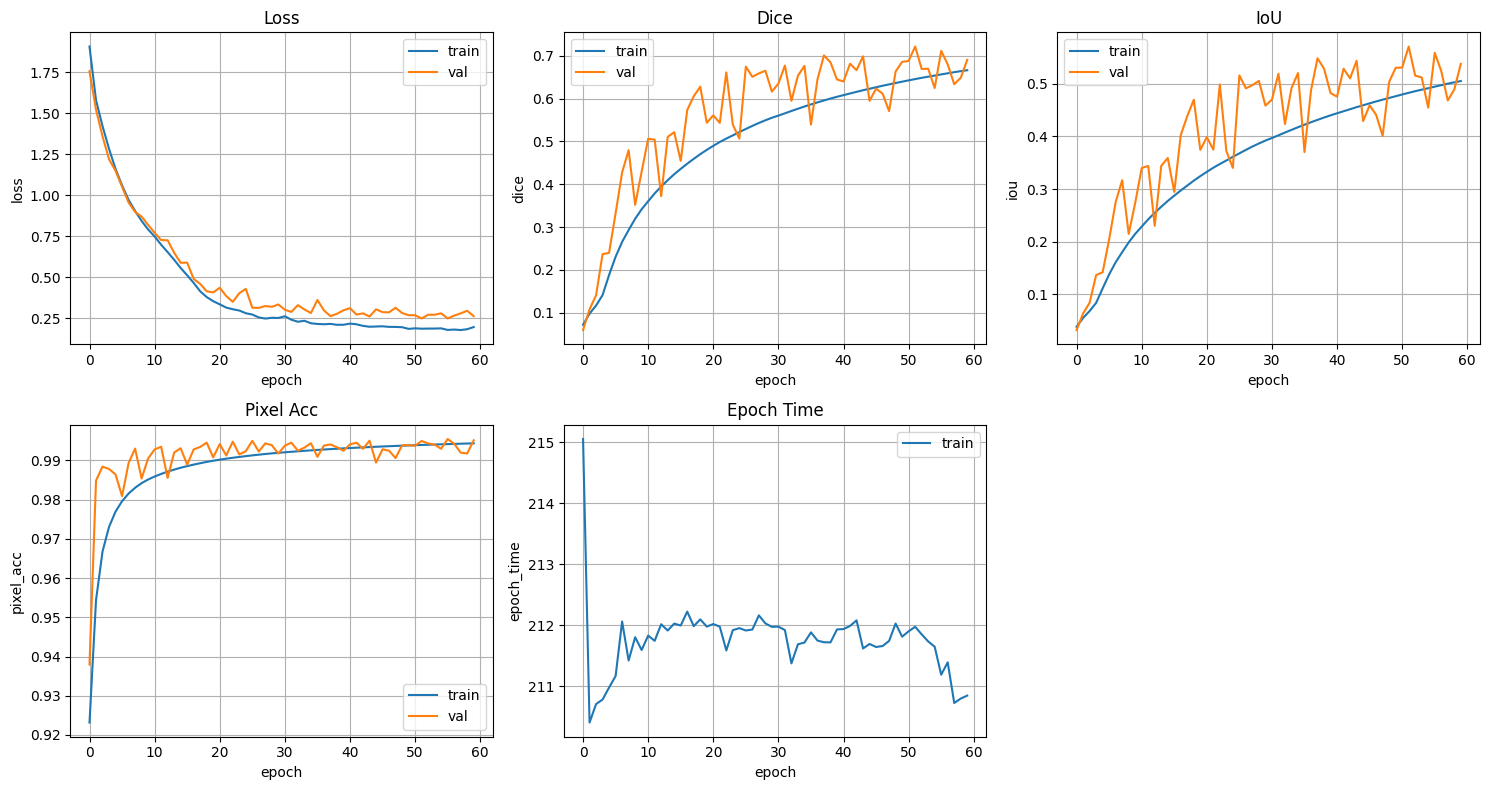

In [26]:
def plot_history(history):
    metrics = [
        ('Loss',        'train_loss',       'val_loss'),
        ('Dice',        'train_dice',       'val_dice'),
        ('IoU',         'train_iou',        'val_iou'),
        ('Pixel Acc',   'train_pixel_acc',  'val_pixel_acc'),
        ('Epoch Time',  'epoch_times',      None),
    ]

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for idx, (title, train_key, val_key) in enumerate(metrics):
        ax = axes[idx]

        # train curve
        ax.plot(history[train_key], label='train')

        # optional val curve (epoch time has no val)
        if val_key is not None:
            ax.plot(history[val_key], label='val')

        ax.set_title(title)
        ax.set_xlabel('epoch')
        ax.set_ylabel(title.lower().replace(' ', '_'))
        ax.grid(True)
        ax.legend()

    # hide the unused last subplot (6th slot)
    axes[-1].axis('off')

    plt.tight_layout()
    plt.show()

plot_history(history)


In [27]:
def compute_metrics_per_class(pred, target, num_classes):
    # pred, target shape: (H, W) with class indices
    metrics = []

    for c in range(num_classes):
        p = (pred == c)
        t = (target == c)

        tp = (p & t).sum().item()
        fp = (p & ~t).sum().item()
        fn = (~p & t).sum().item()
        tn = (~p & ~t).sum().item()

        # avoid zero division
        dice = (2 * tp) / (2 * tp + fp + fn) if (2*tp + fp + fn) > 0 else 0
        iou  = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        acc  = (tp + tn) / (tp + fp + fn + tn)

        metrics.append({
            'class': c,
            'dice': dice,
            'iou': iou,
            'pixel_acc': acc
        })

    return metrics

def evaluate_test(model, dataloader, criterion, num_classes, device):
    model.eval()

    total_loss = 0
    total_pixels = 0

    # aggregate for overall metrics
    agg_tp = torch.zeros(num_classes)
    agg_fp = torch.zeros(num_classes)
    agg_fn = torch.zeros(num_classes)
    agg_tn = torch.zeros(num_classes)

    per_class_results = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            logits = model(images)
            loss = criterion(logits, masks)
            total_loss += loss.item() * images.size(0)

            preds = torch.argmax(logits, dim=1)

            # per-image per-class metrics (optional to store)
            for i in range(preds.size(0)):
                per_class_results.append(
                    compute_metrics_per_class(preds[i].cpu(), masks[i].cpu(), num_classes)
                )

            # aggregated confusion components
            for c in range(num_classes):
                p = (preds == c)
                t = (masks == c)

                agg_tp[c] += (p & t).sum().item()
                agg_fp[c] += (p & ~t).sum().item()
                agg_fn[c] += (~p & t).sum().item()
                agg_tn[c] += (~p & ~t).sum().item()

            total_pixels += images.size(0)

    avg_loss = total_loss / total_pixels

    # overall per-class metrics (aggregated)
    overall = []
    for c in range(num_classes):
        tp = agg_tp[c]
        fp = agg_fp[c]
        fn = agg_fn[c]
        tn = agg_tn[c]

        dice = (2 * tp) / (2 * tp + fp + fn) if (2*tp + fp + fn) > 0 else 0
        iou  = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        acc  = (tp + tn) / (tp + fp + fn + tn)

        overall.append({
            'class': c,
            'dice': dice,
            'iou': iou,
            'pixel_acc': acc
        })

    return {
        'loss': avg_loss,
        'per_class_metrics': overall
    }

In [29]:
results = evaluate_test(model, test_loader, loss_fn, 4, device)

In [30]:
print("Overall loss:", results['loss'])
for i, c in enumerate(results['per_class_metrics']):
    print(f'{c} {CLASSES[i]}')

Overall loss: 0.28685258435351507
{'class': 0, 'dice': tensor(0.9979), 'iou': tensor(0.9959), 'pixel_acc': tensor(0.9959)} Background
{'class': 1, 'dice': tensor(0.5690), 'iou': tensor(0.3976), 'pixel_acc': tensor(0.9983)} NCR/NET (Necrotic)
{'class': 2, 'dice': tensor(0.7114), 'iou': tensor(0.5521), 'pixel_acc': tensor(0.9963)} Edema
{'class': 3, 'dice': tensor(0.6111), 'iou': tensor(0.4400), 'pixel_acc': tensor(0.9979)} Enhancing tumor


In [ ]:
results

In [34]:
mean_dice = np.mean( list(map(lambda v: v['dice'], results['per_class_metrics'])) )
print(f"Mean dice score for all classes: {mean_dice:.4f}")

Mean dice score for all classes: 0.7224


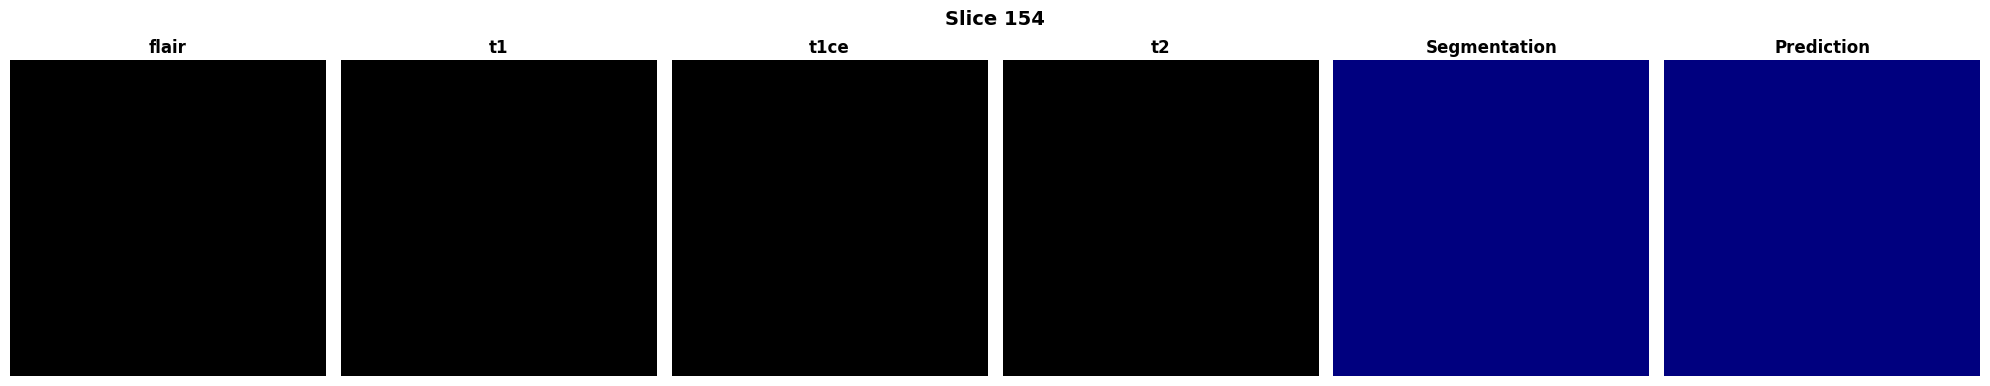

In [35]:
imgs, seg, pred = load_and_predict_patient(patient_folders[5], model, device)
animate_patient(imgs, seg, pred, interval=50, save_path="visualisations/out_2.gif")